In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import random
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
AUTOTUNE = tf.data.experimental.AUTOTUNE

random.seed(1)# setting random seed
main_data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')

2023-05-15 11:33:46.838141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# main_data['patientID'].value_counts()

In [3]:
cancerTypes = ['epithelial', 'inflammatory', 'fibroblast', 'others']
cancerous = ["Y", "N"]

one_hot = pd.get_dummies(main_data['cellTypeName'])
main_data = main_data.drop('cellTypeName',axis = 1)
main_data = main_data.join(one_hot)

main_data
# https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

,InstanceID,patientID,ImageName,cellType,isCancerous,epithelial,fibroblast,inflammatory,others
0,22405,1,22405.png,0,0,0,1,0,0
1,22406,1,22406.png,0,0,0,1,0,0
2,22407,1,22407.png,0,0,0,1,0,0
3,22408,1,22408.png,0,0,0,1,0,0
4,22409,1,22409.png,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
9891,1625,60,1625.png,2,1,1,0,0,0
9892,1626,60,1626.png,2,1,1,0,0,0
9893,1627,60,1627.png,2,1,1,0,0,0
9894,1628,60,1628.png,2,1,1,0,0,0


In [4]:
main_data.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellType        0
isCancerous     0
epithelial      0
fibroblast      0
inflammatory    0
others          0
dtype: int64

In [5]:
main_data = main_data.sample(frac=1).reset_index(drop=True) #shuffles the results

In [6]:
from sklearn.model_selection import GroupShuffleSplit 

splitter = GroupShuffleSplit(n_splits=5, random_state=42)
split = splitter.split(main_data, groups=main_data['patientID'])
splitter.get_n_splits()

5

In [7]:
gs_1 = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
train_test_ix, val_ix = next(gs_1.split(main_data, groups=main_data["patientID"]))
train_test = main_data.loc[train_test_ix]
val = main_data.loc[val_ix]

train_test = train_test.reset_index(drop=True)
gs_2 = GroupShuffleSplit(n_splits=1, train_size=.75, random_state=42)
train_ix, test_ix = next(gs_2.split(train_test, groups=train_test["patientID"]))
train = train_test.loc[train_ix]
test = train_test.loc[test_ix]

# https://stackoverflow.com/questions/68152473/python-split-to-train-test-val-using-groupshufflesplit

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0'),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

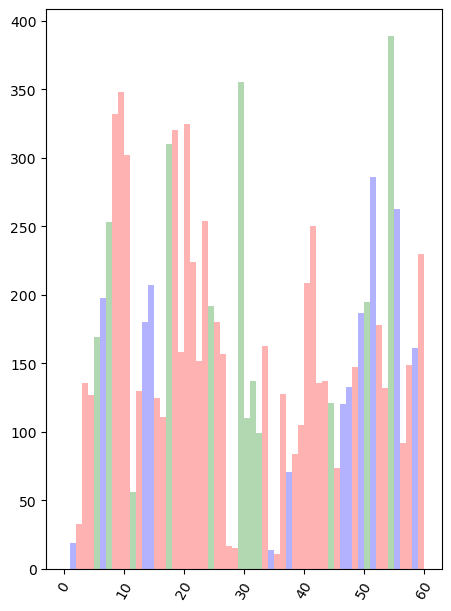

In [8]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.tight_layout(pad=4.0)
plt.hist(x=train['patientID'], alpha=0.3, color='r', bins=60,range=(0,60))
plt.hist(x=val['patientID'], alpha=0.3, color='b', bins=60, range=(0,60))
plt.hist(x=test['patientID'], alpha=0.3, color='g', bins=60, range=(0,60))
plt.xticks(rotation=60)

In [9]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 1
BATCH_SIZE = 256
EPOCHS = 25

In [10]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train['isCancerous'] = train['isCancerous'].astype('str')
val['isCancerous'] = val['isCancerous'].astype('str')
test['isCancerous'] = test['isCancerous'].astype('str')

train_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

train_generator = train_gen.flow_from_dataframe(
        dataframe=train,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='binary')

validation_generator = val_gen.flow_from_dataframe(
        dataframe=val,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='binary')

test_generator = test_gen.flow_from_dataframe(
        dataframe=test,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=1,
        class_mode='binary')

Found 5671 validated image filenames belonging to 2 classes.
Found 1839 validated image filenames belonging to 2 classes.
Found 2386 validated image filenames belonging to 2 classes.


## Baseline

In [12]:
model = tf.keras.Sequential([
    layers.Flatten(input_shape=INPUT_DIM),
    layers.Dense(OUTPUT_CLASSES, activation="sigmoid")
])

2023-05-15 11:33:51.478214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 1)                 2188      
                                                                 
Total params: 2,188
Trainable params: 2,188
Non-trainable params: 0
_________________________________________________________________


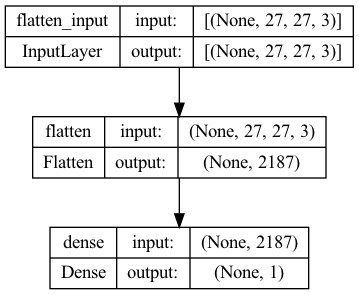

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
from keras.optimizers import SGD
opt = SGD(learning_rate=0.01)
model.compile(optimizer = opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy(), f1_m,precision_m, recall_m])

history = model.fit(train_generator, validation_data = validation_generator, epochs=EPOCHS)

Epoch 1/25
23/23 [==============================] - 4s 121ms/step - loss: 0.9543 - binary_accuracy: 0.5084 - f1_m: 0.2717 - precision_m: 0.1907 - recall_m: 0.4731 - val_loss: 0.6587 - val_binary_accuracy: 0.6650 - val_f1_m: 0.7248 - val_precision_m: 0.6321 - val_recall_m: 0.8527
Epoch 2/25
23/23 [==============================] - 2s 76ms/step - loss: 0.8862 - binary_accuracy: 0.5461 - f1_m: 0.3124 - precision_m: 0.2392 - recall_m: 0.4885 - val_loss: 0.9721 - val_binary_accuracy: 0.4970 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/25
23/23 [==============================] - 2s 75ms/step - loss: 0.7317 - binary_accuracy: 0.5858 - f1_m: 0.3177 - precision_m: 0.3315 - recall_m: 0.4389 - val_loss: 0.7974 - val_binary_accuracy: 0.5030 - val_f1_m: 0.6697 - val_precision_m: 0.5038 - val_recall_m: 1.0000
Epoch 4/25
23/23 [==============================] - 2s 73ms/step - loss: 0.7684 - binary_accuracy: 0.5710 - f1_m: 0.3333 - precision_m: 0.2884 - recal

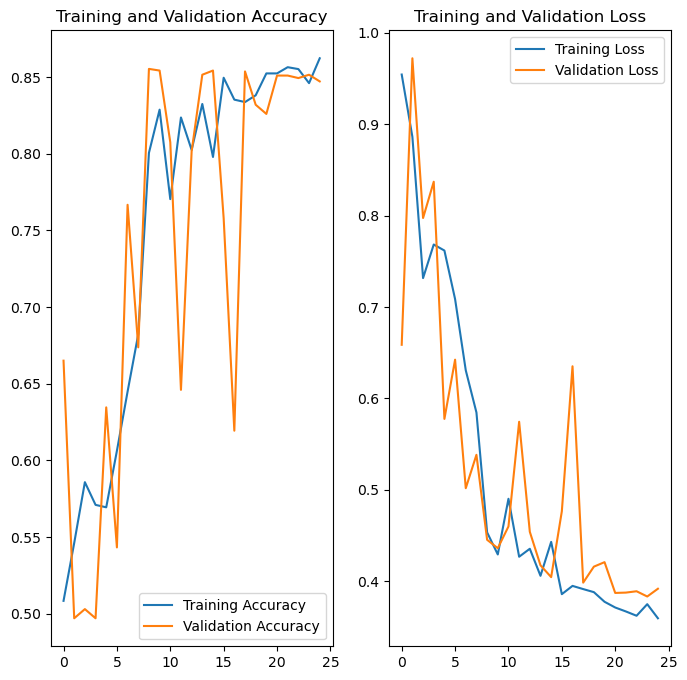

In [16]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
results=model.evaluate(test_generator)
print("Loss: {}".format(round(results[0], 3)))
print("Accuracy: {}".format(round(results[1], 3)))

2386/2386 [==============================] - 2s 965us/step - loss: 0.3603 - binary_accuracy: 0.8659 - f1_m: 0.3315 - precision_m: 0.3315 - recall_m: 0.3315
Loss: 0.36
Accuracy: 0.866


## CNN

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = tf.keras.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(27, 27, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 512)         295424    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 512)       

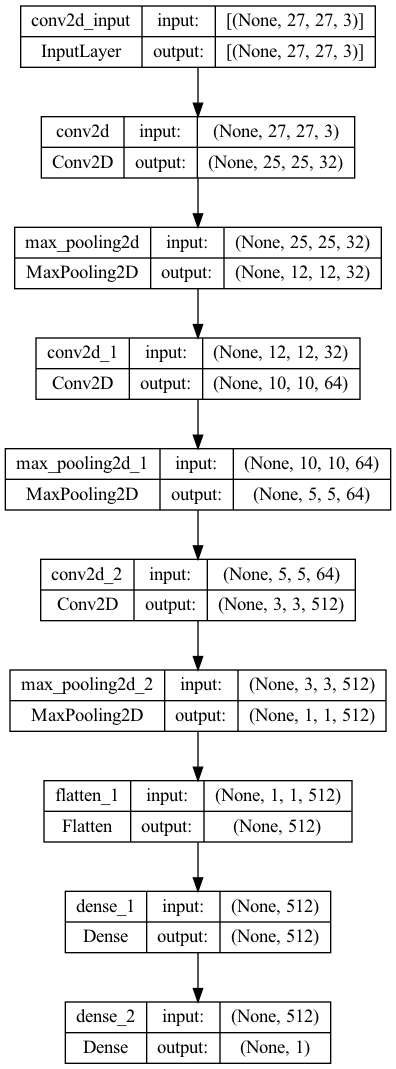

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [21]:
model.compile(optimizer = 'adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

history = model.fit(train_generator, validation_data = validation_generator, epochs=EPOCHS)

Epoch 1/25
23/23 [==============================] - 5s 190ms/step - loss: 0.6316 - binary_accuracy: 0.6357 - val_loss: 0.5611 - val_binary_accuracy: 0.6895
Epoch 2/25
23/23 [==============================] - 5s 210ms/step - loss: 0.4409 - binary_accuracy: 0.8037 - val_loss: 0.4194 - val_binary_accuracy: 0.8222
Epoch 3/25
23/23 [==============================] - 6s 267ms/step - loss: 0.3698 - binary_accuracy: 0.8392 - val_loss: 0.7438 - val_binary_accuracy: 0.6803
Epoch 4/25
23/23 [==============================] - 5s 221ms/step - loss: 0.3503 - binary_accuracy: 0.8506 - val_loss: 0.4010 - val_binary_accuracy: 0.8336
Epoch 5/25
23/23 [==============================] - 6s 250ms/step - loss: 0.2933 - binary_accuracy: 0.8767 - val_loss: 0.3788 - val_binary_accuracy: 0.8450
Epoch 6/25
23/23 [==============================] - 6s 272ms/step - loss: 0.2887 - binary_accuracy: 0.8790 - val_loss: 0.5373 - val_binary_accuracy: 0.7966
Epoch 7/25
23/23 [==============================] - 4s 186ms/ste

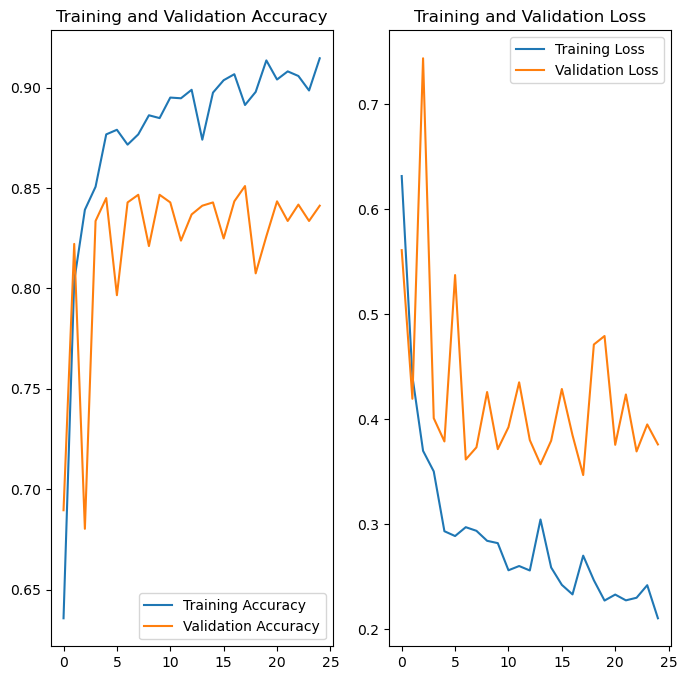

In [22]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting

In [23]:
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               data_format='channels_last')

train_generator = train_gen.flow_from_dataframe(
        dataframe=train,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 5671 validated image filenames belonging to 2 classes.


In [24]:
model = tf.keras.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(27, 27, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer = 'adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

history = model.fit(train_generator, validation_data = validation_generator, epochs=EPOCHS)

Epoch 1/25
23/23 [==============================] - 7s 268ms/step - loss: 0.6350 - binary_accuracy: 0.6272 - val_loss: 0.7547 - val_binary_accuracy: 0.5003
Epoch 2/25
23/23 [==============================] - 7s 310ms/step - loss: 0.5067 - binary_accuracy: 0.7632 - val_loss: 0.6773 - val_binary_accuracy: 0.6395
Epoch 3/25
23/23 [==============================] - 7s 297ms/step - loss: 0.3953 - binary_accuracy: 0.8268 - val_loss: 0.4601 - val_binary_accuracy: 0.7961
Epoch 4/25
23/23 [==============================] - 7s 299ms/step - loss: 0.3727 - binary_accuracy: 0.8325 - val_loss: 0.7736 - val_binary_accuracy: 0.6754
Epoch 5/25
23/23 [==============================] - 7s 300ms/step - loss: 0.3357 - binary_accuracy: 0.8519 - val_loss: 0.6713 - val_binary_accuracy: 0.7455
Epoch 6/25
23/23 [==============================] - 7s 328ms/step - loss: 0.3285 - binary_accuracy: 0.8575 - val_loss: 0.4660 - val_binary_accuracy: 0.8140
Epoch 7/25
23/23 [==============================] - 7s 325ms/ste

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Adding Extra data sheet

In [ ]:
model.save('./Model')
extra_data = pd.read_csv('./Image_classification_data/data_labels_extraData.csv')

In [ ]:
extra_data['isCancerous'].value_counts()

### Simply adding new data

In [ ]:
# new image dataset based on new data
model = keras.models.load_model('./Model')
extra_data['isCancerous'] = extra_data['isCancerous'].astype('str')

extra_generator = train_gen.flow_from_dataframe(
        dataframe=extra_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='binary')



history = model.fit(extra_generator,validation_data = validation_generator, epochs=EPOCHS)

#https://machinelearningmastery.com/update-neural-network-models-with-more-data/

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### rebuilding using old and new datasets

In [ ]:
all_data = train.append(extra_data)
all_data

In [ ]:
# new image dataset based on new data
model = keras.models.load_model('./Model')

all_data['isCancerous'] = all_data['isCancerous'].astype('str')

all_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

all_generator = train_gen.flow_from_dataframe(
        dataframe=all_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='binary')


model.compile(optimizer = 'adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

history = model.fit(all_generator, validation_data = validation_generator, epochs=EPOCHS)

#https://machinelearningmastery.com/update-neural-network-models-with-more-data/

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Bottom Up

In [ ]:
extra_data = pd.read_csv('./Image_classification_data/data_labels_extraData.csv')
new_data = main_data.append(extra_data)

gs_1 = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
train_test_ix, val_ix = next(gs_1.split(new_data, groups=new_data["patientID"]))
train_test = new_data.iloc[train_test_ix]
val = new_data.iloc[val_ix]

train_test = train_test.reset_index(drop=True)
gs_2 = GroupShuffleSplit(n_splits=1, train_size=.75, random_state=42)
train_ix, test_ix = next(gs_2.split(train_test, groups=train_test["patientID"]))
train = train_test.loc[train_ix]
test = train_test.loc[test_ix]

In [ ]:
# new image dataset based on new data




model = tf.keras.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(27, 27, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

all_data['isCancerous'] = all_data['isCancerous'].astype('str')

all_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

all_generator = train_gen.flow_from_dataframe(
        dataframe=all_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='binary')


model.compile(optimizer = 'adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

history = model.fit(all_generator, validation_data = validation_generator, epochs=EPOCHS)

#https://machinelearningmastery.com/update-neural-network-models-with-more-data/

## Testing

In [ ]:
results=model.evaluate(test_generator)
print("Loss: {}".format(round(results[0], 3)))
print("Accuracy: {}".format(round(results[1], 3)))

In [ ]:
model.save('./Model')

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import plot_confusion_matrix

predictions=model.predict(test_generator)
predicted_labels = np.round(predictions).flatten()

cm = metrics.confusion_matrix(y_true=test_generator.classes, y_pred=predicted_labels) 

cm

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()